In [2]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.image as mpimg
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import PIL
import torch
from torch import nn
from sklearn.feature_extraction.image import extract_patches_2d
!pip install patchify
from patchify import patchify
from sklearn.model_selection import train_test_split
from google.colab import drive
from PIL import Image, ImageOps
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
drive.mount('/content/drive')

path = r'/content/drive/MyDrive/dissertation_seg_data'

input_path = os.path.join(path,"input")

mask_path = os.path.join(path,"mask")

train_split = 0.8

Mounted at /content/drive


In [4]:
image_input_path = sorted([ os.path.join(input_path, fname) for fname in os.listdir(input_path) if fname.endswith(".png") ])

len(image_input_path)

1306

In [5]:
image_mask_path = sorted([ os.path.join(mask_path, fname) for fname in os.listdir(mask_path) if fname.endswith(".png")])

len(image_mask_path)

1306

In [ ]:
patch_size = 128

def load_images(path):

    images = []

    for image in tqdm(range(len(path))):
        #input 
        inp_path = path[image]
        img = Image.open(inp_path)
        img = (np.array(img)/255)

        size_x = (img.shape[0] // patch_size) * patch_size  
        size_y = (img.shape[1] // patch_size) * patch_size 

        img_patches = np.squeeze(patchify(np.array(img[0:size_x, 0:size_y]), (patch_size, patch_size, 3), step=patch_size))
        
        for x in range(img_patches.shape[0]):
            for y in range(img_patches.shape[1]):
                patch = img_patches[x,y]
                images.append(np.squeeze(patch))

    return images

def load_mask(path):

    images = []

    for image in tqdm(range(len(path))):
        #input 
        inp_path = path[image]
        img = Image.open(inp_path)
        img = ImageOps.grayscale(img)
        img = (np.array(img))

        size_x = (img.shape[0] // patch_size) * patch_size  
        size_y = (img.shape[1] // patch_size) * patch_size 

        img = np.array(img[0:size_x, 0:size_y])
        
        img_patches = np.squeeze(patchify(img, (patch_size, patch_size), step=patch_size))

        for x in range(img_patches.shape[0]):
            for y in range(img_patches.shape[1]):
                patch = img_patches[x,y]
                images.append(np.squeeze(patch))

    return images

X_data = load_images(image_input_path)

#Y_data = load_mask(image_mask_path)

#X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.15, random_state=42)


 12%|█▏        | 153/1306 [02:08<21:20,  1.11s/it]

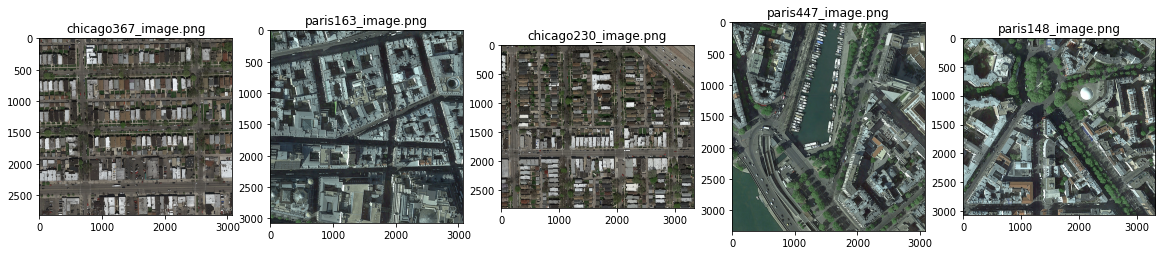

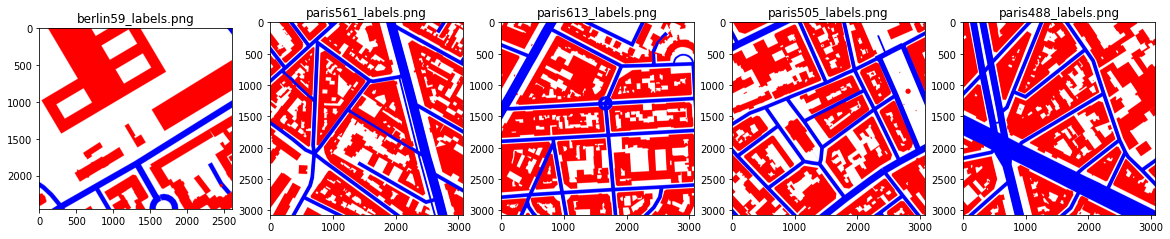

In [11]:
def show_data(directory):
    plt.figure(figsize=(20,20))
    for i in range(5):
        file = random.choice(os.listdir(directory))
        image_path= os.path.join(directory, file)
        img = Image.open(image_path)
        ax=plt.subplot(1,5,i+1)
        ax.title.set_text(file)
        plt.imshow(img)

show_data(input_path)

show_data(mask_path)

In [12]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GaussianNoise
from keras.layers import Conv2D, MaxPool2D, Input, concatenate, Conv2DTranspose
from keras.layers.convolutional import MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, InceptionV3
from sklearn.model_selection import train_test_split

In [13]:
def unet(img_shape):
    # input layer shape is equal to patch image size
    inputs = Input(shape=img_shape)

    previous_block_activation = inputs  # Set aside residual

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [32, 64, 128, 256]:
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
        x = Dropout(0.1)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5

    # Expansive path: Second half of the network: upsampling inputs
    for f in reversed([32, 64, 128, 256]):
        x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = concatenate([x, contraction[f'conv{f}']])
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(0.2)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = Conv2D(filters=4, kernel_size=(1, 1), activation="softmax")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)
     

In [14]:
model = unet(img_shape=(patch_size, patch_size, 3))

model.summary()

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", jaccard_index])

model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test), callbacks=callbacks_list, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 32  0           ['conv2d[0][0]']                 
                                )                                                             

NameError: ignored